## List of Contents
1. Prediction
    - [Import Libraries](#Import-Libraries)
        - [myutils.py](myutils.py)
    - [Loading the datasets](#Loading-the-datasets)
    - [Descriptive Statistics](#Descriptive-Statistics)
    - [Correlation Analysis](#Correlation-Analysis)
    - [Inferential-Statistics](#Inferential-Statistics)
        - [Pearson Correlation Coefficient Test](#Pearson-Correlation-Coefficient-Test)
        - [T-test to Calculate Confidence Intervals For Population](#T-test-to-calculate-confidence-intervals-for-population)
        - [Independent Samples t-test](#Independent-Samples-t-test)
        - [Analysis of Variance](#Analysis-of-Variance)
        - [Levene's Test](#Levene's-Test)
        - [Mann-Whitney U Test](#Mann-Whitney-U-Test)
        - [Wilcoxon Signed-rank Test](#Wilcoxon-Signed-rank-Test)
    - [Regression Models](#Regression-Models)
        - [Linear Regression](#Linear-Regression)
        - [Lasso Regression to Identify the Most Important Construction Materials](#Lasso-Regression-to-help-narrow-down-the-most-important-construction-materials)
        - [Ridge Regression](#Ridge-Regression)
    - [Classification Models](#Classification)
        - [Logistic Regression](#Logistic-Regression)
        - [Decision Tree Classifier](#Decision-Tree-Classifier)
        - [Random Forest](#Random-Forest-Classifier)
        - [Support Vector Machine Classifier](#Support-Vector-Machine-Classifier)
2. [Sentiment Analysis](#Sentiment-Analysis)<br>
NOTE: Commenting out below section because fetching Reddit takes a while and won't be preferred when running with all cells. Please setup the Reddit credentials if you are going to uncomment and run these cells.
    - [Loading Reddit Credentials](#Loading-Reddit-Credentials)
    - [Fetching Data from Reddit API](#Fetching-data-from-Reddit-API)
    - [Data Pre-Processing and Sentiment Analysis](#Data-Pre-Processing-and-Sentiment-Analysis)
    - [Plot of SentimentIntensityAnalyzer and TextBlob](#Plot-of-SentimentIntensityAnalyzer-and-TextBlob)
    - [Persist the Dataset to MongoDB](#Persist-the-dataset-to-MongoDB)
3. [Main Dashboard](#Main-Dashboard)
    - [Loading and Preparing Data from MongoDB to Create Visualization](#Loading-and-Preparing-Data-from-MongoDB-to-Create-Visualization)
    - [Preparing Panel for Sentiment Analysis](#Preparing-Panel-for-Sentiment-Analysis)
    - [Preparing Panel for Machine Learning](#Preparing-Panel-for-Machine-learning)
    - [Interactive Dashboard using Panel](#Interactive-Dashboard)

## Import Libraries

In [112]:
# Import all the required libraries as well as custom functions from myutils.py
from myutils import *
warnings.filterwarnings('ignore')
# Rerun this cell it shows "Javascript error adding output!"

Listing all versions of packages<br>
!pip show conda pandas numpy seaborn matplotlib scipy scikit-learn hvplot holoviews panel nltk pymongo textblob | grep -e Name -e Version <br>
- conda==23.3.1
- pandas==1.5.3
- numpy==1.24.3
- seaborn==0.12.2
- matplotlib==3.7.1
- scipy==1.10.1
- scikit-learn1.2.2
- hvplot==0.8.3
- holoviews==1.16.0
- panel==0.14.3
- nltk==3.7
- pymongo==4.3.3
- textblob==0.17.1

## Loading the datasets

In [2]:
# Source: https://data.gov.ie/dataset/beq04-onstruction-sector-base-2015100-by-type-of-building-and-construction-year-and-statistic-fb86?package_type=dataset
# License: Creative Commons Attribution 4.0
#Accessed: 27 April 2023
total_production_indices_df = pd.read_csv("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/BEQ04/CSV/1.0/en")

# Source: https://data.gov.ie/dataset/wpm28-wholesale-price-index-excl-vat-for-building-and-construction-materials?package_type=dataset
# License: Creative Commons Attribution 4.0
wholesale_price_index_df = pd.read_csv("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/CSV/1.0/en")
wholesale_price_index_df.iloc[[0,-1]]

,STATISTIC,Statistic Label,TLIST(M1),Month,C01409V03262,Type of Material,UNIT,VALUE
0,WPM28C01,Wholesale Price Index (Excl VAT) for Building ...,201501,2015 January,-,Materials,Base 2015=100,99.2
11999,WPM28C03,Percentage Change over 12 month in Wholesale P...,202304,2023 April,709,All other products,%,9.9


In [3]:
# Filter the DF to only contain price indices
wholesale_price_index_only_df = wholesale_price_index_df[wholesale_price_index_df['Statistic Label'] == 'Wholesale Price Index (Excl VAT) for Building and Construction Materials'].copy()

# Adding quarters from months
wholesale_price_index_only_df['Quarter'] = pd.to_datetime(wholesale_price_index_only_df['TLIST(M1)'].astype('str')+'01', format='%Y%m%d').dt.to_period('Q')

# Pivot the types of material to columns
construction_materials_price_df = wholesale_price_index_only_df.pivot(index=f'TLIST(M1)', columns='Type of Material', values='VALUE').reset_index()

# Adding quarters from months
construction_materials_price_df['Quarter'] = pd.to_datetime(construction_materials_price_df['TLIST(M1)'].astype('str')+'01', format='%Y%m%d').dt.to_period('Q').astype('str')
construction_materials_price_df.drop(columns=['TLIST(M1)'], axis=1, inplace=True)
construction_materials_price_df.head(2)

Type of Material,All other materials,All other metal fittings,All other products,Bituminous emulsions,Bituminous macadam and asphalt,"Bituminous macadam, asphalt and bituminous emulsions",Cement,Concrete blocks and bricks,Copper pipes and fittings,Electrical fittings,...,Rough timber (including plain sawn),Rough timber (softwood),Sand and gravel,Stone,"Stone, sand and gravel",Structural steel,Structural steel and reinforcing metal,Structural steel fabricated metal,Wooden windows and doors,Quarter
0,99.2,99.2,99.3,102.3,99.6,99.7,100.0,100.2,98.7,98.5,...,99.5,99.9,98.0,95.3,95.7,97.6,98.8,97.3,99.9,2015Q1
1,99.1,99.2,99.1,101.6,94.8,95.1,100.0,100.6,98.7,98.7,...,99.9,99.9,96.1,93.5,93.9,97.7,98.9,97.3,99.9,2015Q1


### Descriptive Statistics

In [4]:
construction_materials_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 41 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   All other materials                                   100 non-null    float64
 1   All other metal fittings                              100 non-null    float64
 2   All other products                                    100 non-null    float64
 3   Bituminous emulsions                                  100 non-null    float64
 4   Bituminous macadam and asphalt                        100 non-null    float64
 5   Bituminous macadam, asphalt and bituminous emulsions  100 non-null    float64
 6   Cement                                                100 non-null    float64
 7   Concrete blocks and bricks                            100 non-null    float64
 8   Copper pipes and fittings                             100 non

In [5]:
construction_materials_price_df.shape

(100, 41)

In [6]:
print('Check null values:')
construction_materials_price_df.isnull().sum()

Check null values:


Type of Material
All other materials                                     0
All other metal fittings                                0
All other products                                      0
Bituminous emulsions                                    0
Bituminous macadam and asphalt                          0
Bituminous macadam, asphalt and bituminous emulsions    0
Cement                                                  0
Concrete blocks and bricks                              0
Copper pipes and fittings                               0
Electrical fittings                                     0
Glass                                                   0
HVAC (heating and ventilation equipment)                0
Insulating materials                                    0
Lighting equipment                                      0
Machined, treated engineered timber                     0
Materials                                               0
Other concrete products (excluding precast concrete)   

In [7]:
construction_materials_price_df[['Other concrete products (excluding precast concrete)', 'Precast concrete']].tail()

Type of Material,Other concrete products (excluding precast concrete),Precast concrete
95,125.8,155.3
96,124.2,160.5
97,NaN,NaN
98,NaN,NaN
99,NaN,NaN


In [8]:
print('Check duplicates:')
construction_materials_price_df.duplicated().sum()

Check duplicates:


0

In [9]:
desc = construction_materials_price_df.describe()
desc

Type of Material,All other materials,All other metal fittings,All other products,Bituminous emulsions,Bituminous macadam and asphalt,"Bituminous macadam, asphalt and bituminous emulsions",Cement,Concrete blocks and bricks,Copper pipes and fittings,Electrical fittings,...,Rough timber (hardwood),Rough timber (including plain sawn),Rough timber (softwood),Sand and gravel,Stone,"Stone, sand and gravel",Structural steel,Structural steel and reinforcing metal,Structural steel fabricated metal,Wooden windows and doors
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,107.891000,108.464000,106.257000,104.482000,102.756000,102.808000,117.515000,105.55200,107.544000,109.192000,...,106.239000,120.575000,122.365000,115.676000,105.88700,107.525000,127.654000,124.538000,128.678000,109.117000
std,9.972154,5.525323,7.344307,12.425888,6.745359,6.870353,19.300544,8.42576,12.603041,11.946714,...,9.212046,29.320915,32.081872,9.394369,6.39829,6.516465,31.898473,31.227089,32.694406,12.215622
min,99.000000,99.200000,99.000000,90.400000,94.800000,95.100000,100.000000,99.00000,94.100000,98.500000,...,93.000000,99.500000,99.900000,90.800000,93.50000,93.900000,97.600000,98.800000,97.300000,99.900000
25%,101.600000,104.200000,101.700000,95.600000,99.275000,99.300000,100.000000,100.87500,100.300000,102.050000,...,100.300000,101.200000,101.300000,110.975000,102.17500,103.900000,110.350000,106.325000,111.750000,100.200000
50%,104.700000,109.100000,104.000000,102.350000,100.500000,100.400000,114.600000,102.40000,103.350000,103.900000,...,100.300000,106.800000,106.700000,117.450000,104.35000,106.600000,120.450000,113.600000,122.700000,105.000000
75%,107.125000,115.400000,105.700000,106.850000,102.500000,102.300000,123.100000,105.12500,109.075000,109.375000,...,107.600000,127.025000,129.500000,122.525000,107.52500,109.525000,124.125000,120.575000,124.500000,107.400000
max,135.600000,119.100000,127.200000,137.700000,123.400000,123.700000,168.600000,136.00000,141.900000,138.400000,...,126.100000,192.800000,201.200000,133.000000,127.50000,128.200000,222.400000,205.700000,229.900000,140.200000


In [10]:
# Display only the construction materials whose price indices have standard deviation higher than 20
columns_with_high_std = desc.columns[desc.loc['std'] > 20]
desc[columns_with_high_std]

Type of Material,"Machined, treated engineered timber",Other structural steel,Other treated timber,Plaster,Reinforcing metal,Rough timber (including plain sawn),Rough timber (softwood),Structural steel,Structural steel and reinforcing metal,Structural steel fabricated metal
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,115.079000,119.310000,122.31400,122.012000,119.790000,120.575000,122.365000,127.654000,124.538000,128.678000
std,26.726657,32.485939,44.93026,26.717203,32.784902,29.320915,32.081872,31.898473,31.227089,32.694406
min,97.800000,95.700000,95.30000,98.400000,97.100000,99.500000,99.900000,97.600000,98.800000,97.300000
25%,99.100000,99.600000,95.30000,104.125000,100.775000,101.200000,101.300000,110.350000,106.325000,111.750000
50%,104.000000,104.650000,102.80000,112.800000,103.600000,106.800000,106.700000,120.450000,113.600000,122.700000
75%,105.300000,121.175000,104.70000,125.625000,115.150000,127.025000,129.500000,124.125000,120.575000,124.500000
max,174.800000,210.500000,216.60000,206.300000,201.000000,192.800000,201.200000,222.400000,205.700000,229.900000


Above construction materials have higher mean than median, so they exhibit postive skew i.e. the tail of the distribution extends towards higher values. In other words, it indicates presence of some outliers or extreme values in the right tail. Similarly, higher standard deviation values imply that the prices of these construction materials have been more volatile or widely spread.

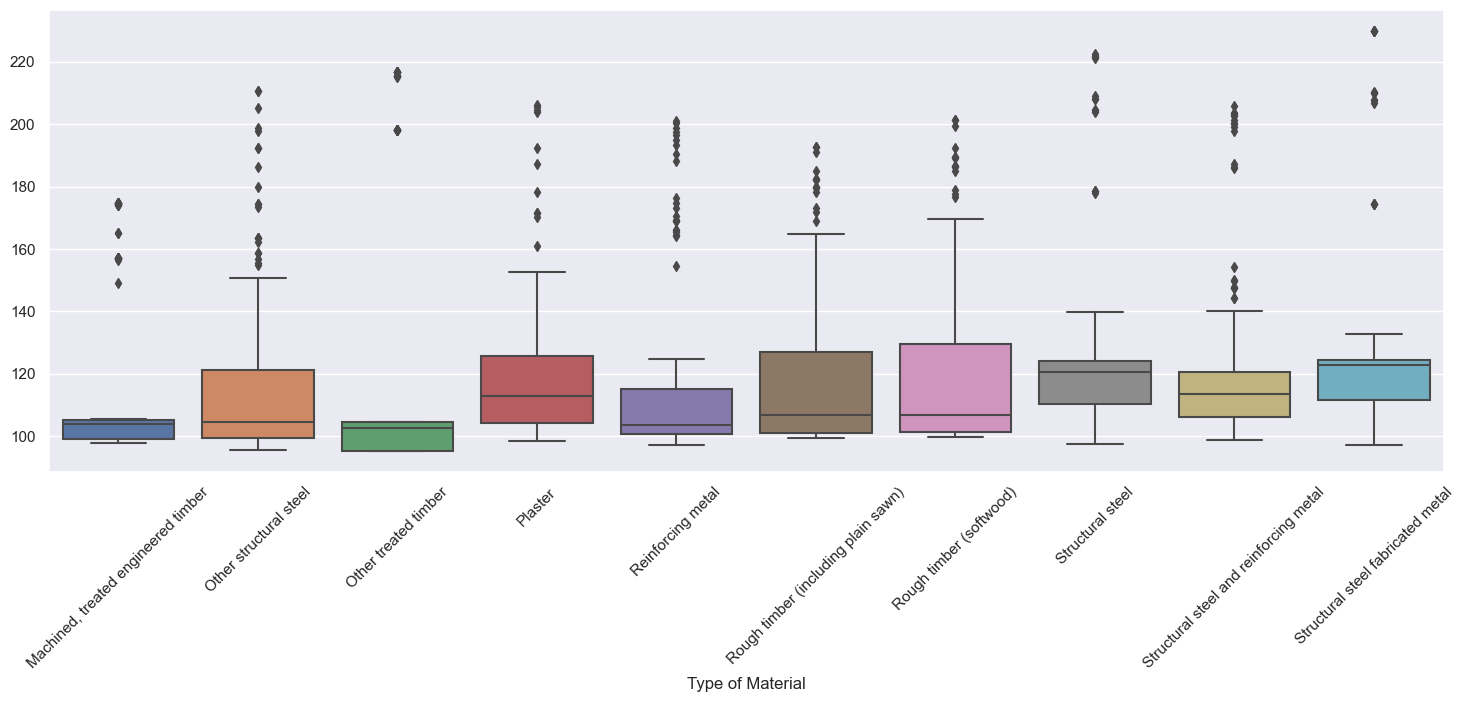

In [11]:
# Boxplot above materials to visualize the outliers
sns.set(rc={'figure.figsize':(18,6)})
sns.boxplot(construction_materials_price_df[columns_with_high_std])
plt.xticks(rotation=45)
plt.show()

In [12]:
# Apply Box-Cox transformation to each column
transformed_data = pd.DataFrame()
for material in construction_materials_price_df.columns[:-1]: # Except last column i.e. Quarter
    transformed_data[material], _ = stats.boxcox(construction_materials_price_df[material])
    
transformed_data.describe()

,All other materials,All other metal fittings,All other products,Bituminous emulsions,Bituminous macadam and asphalt,"Bituminous macadam, asphalt and bituminous emulsions",Cement,Concrete blocks and bricks,Copper pipes and fittings,Electrical fittings,...,Rough timber (hardwood),Rough timber (including plain sawn),Rough timber (softwood),Sand and gravel,Stone,"Stone, sand and gravel",Structural steel,Structural steel and reinforcing metal,Structural steel fabricated metal,Wooden windows and doors
count,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,9.775232e-02,0.541180,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,7.524562e+05,1.968270e-01,2.680808e-01,3.028337e-01,2.413850e-01,3.206226e-01,1.083046e-01
std,1.394770e-16,0.000009,5.579081e-17,2.832630e-12,6.973851e-17,1.534247e-16,3.914728e-09,5.579081e-17,8.559072e-16,6.973851e-17,...,4.145910e-15,1.511882e-12,4.754254e-12,1.801114e+05,2.853183e-12,1.516428e-09,1.938257e-08,3.679671e-10,4.628460e-08,1.115816e-16
min,9.775232e-02,0.541163,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,3.496499e+05,1.968270e-01,2.680808e-01,3.028336e-01,2.413850e-01,3.206225e-01,1.083046e-01
25%,9.775232e-02,0.541173,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,6.487603e+05,1.968270e-01,2.680808e-01,3.028337e-01,2.413850e-01,3.206226e-01,1.083046e-01
50%,9.775232e-02,0.541181,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,7.726051e+05,1.968270e-01,2.680808e-01,3.028337e-01,2.413850e-01,3.206226e-01,1.083046e-01
75%,9.775232e-02,0.541191,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,8.801430e+05,1.968270e-01,2.680808e-01,3.028337e-01,2.413850e-01,3.206226e-01,1.083046e-01
max,9.775232e-02,0.541195,8.118399e-02,1.917291e-01,6.644162e-02,6.360001e-02,2.742730e-01,6.385546e-02,1.451562e-01,8.956921e-02,...,1.530098e-01,1.880208e-01,1.968504e-01,1.133207e+06,1.968270e-01,2.680808e-01,3.028337e-01,2.413850e-01,3.206227e-01,1.083046e-01


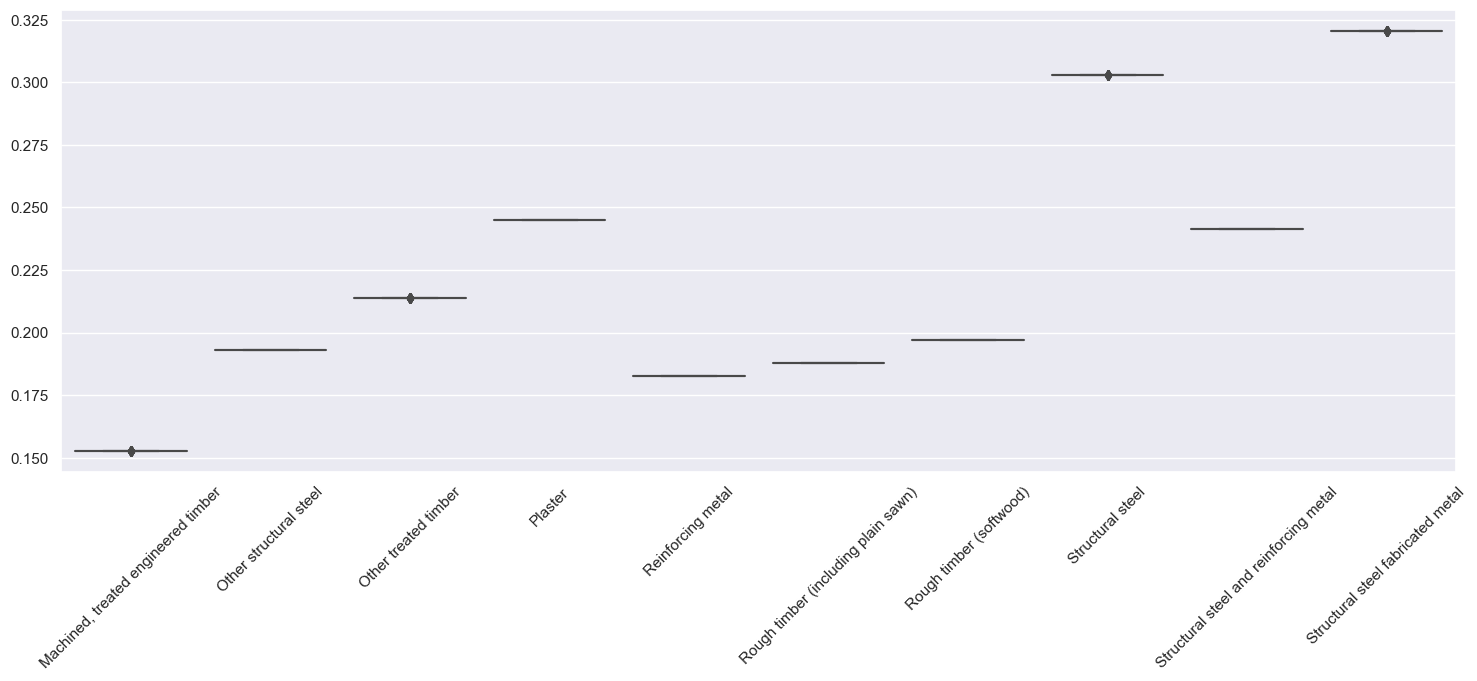

In [13]:
sns.boxplot(transformed_data[columns_with_high_std])
plt.xticks(rotation=45)
plt.show()

The Box-Cox Transformation represents the original data in different form. Since the transformation is applied to each column, different estimated lambda parameter can be used. Few considerations for its usage are: Interpretability, Impact on Relationships, Model Assumptions and Reversibility.

In [14]:
# Descriptive statistics for dataset of Production in Construction Indices
value_of_production_df = total_production_indices_df.loc[total_production_indices_df['Statistic Label']=='Value of Production Index in Building and Construction (Seasonally Adjusted)'].pivot(index='Quarter', columns='Type of Building and Construction', values='VALUE').reset_index()
value_of_production_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Quarter                                 92 non-null     object 
 1   All building and construction           92 non-null     float64
 2   Building (excluding civil engineering)  92 non-null     float64
 3   Civil engineering                       92 non-null     float64
 4   Non-residential building                92 non-null     float64
 5   Residential building                    92 non-null     float64
dtypes: float64(5), object(1)
memory usage: 4.4+ KB


In [15]:
print('Null values:')
value_of_production_df.isnull().sum()

Null values:


Type of Building and Construction
Quarter                                   0
All building and construction             0
Building (excluding civil engineering)    0
Civil engineering                         0
Non-residential building                  0
Residential building                      0
dtype: int64

In [16]:
print('Duplicate values:')
value_of_production_df.duplicated().sum()

Duplicate values:


0

In [17]:
value_of_production_df.describe()

Type of Building and Construction,All building and construction,Building (excluding civil engineering),Civil engineering,Non-residential building,Residential building
count,92.000000,92.000000,92.000000,92.000000,92.000000
mean,162.751681,184.160418,112.309565,123.680481,268.608427
std,71.031275,97.857249,26.451901,29.556384,219.300998
min,71.680349,65.295328,58.781197,70.220966,55.142426
25%,102.071686,102.169554,96.000412,100.417792,99.642029
50%,153.174767,160.765608,106.311426,121.523531,153.648507
75%,194.994284,236.495122,131.150151,149.714453,396.389002
max,341.886209,421.850304,170.315616,182.060597,789.911977


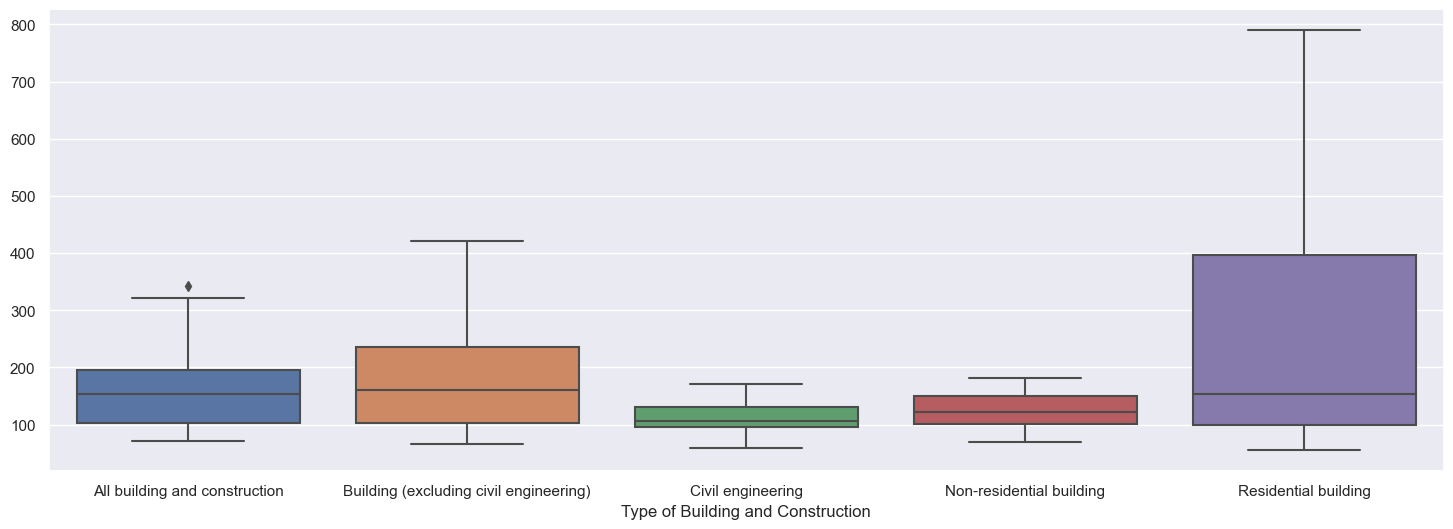

In [18]:
sns.boxplot(value_of_production_df);

Production in Residential buildings stands out from rest of the construction types and has biggest variation. It has had highest maximum (789.9) and lowest minimum (55) values. Its mean/average is also highest at 268.6 with standard deviation of 219.3. And the mean 268.6 is lot higher than median 153.6, which represents a positive skew. <br>
On the other hand, All building and construction had an outlier. And Non-residential building seems more-or-less balanced.

<Axes: xlabel='Non-residential building', ylabel='Count'>

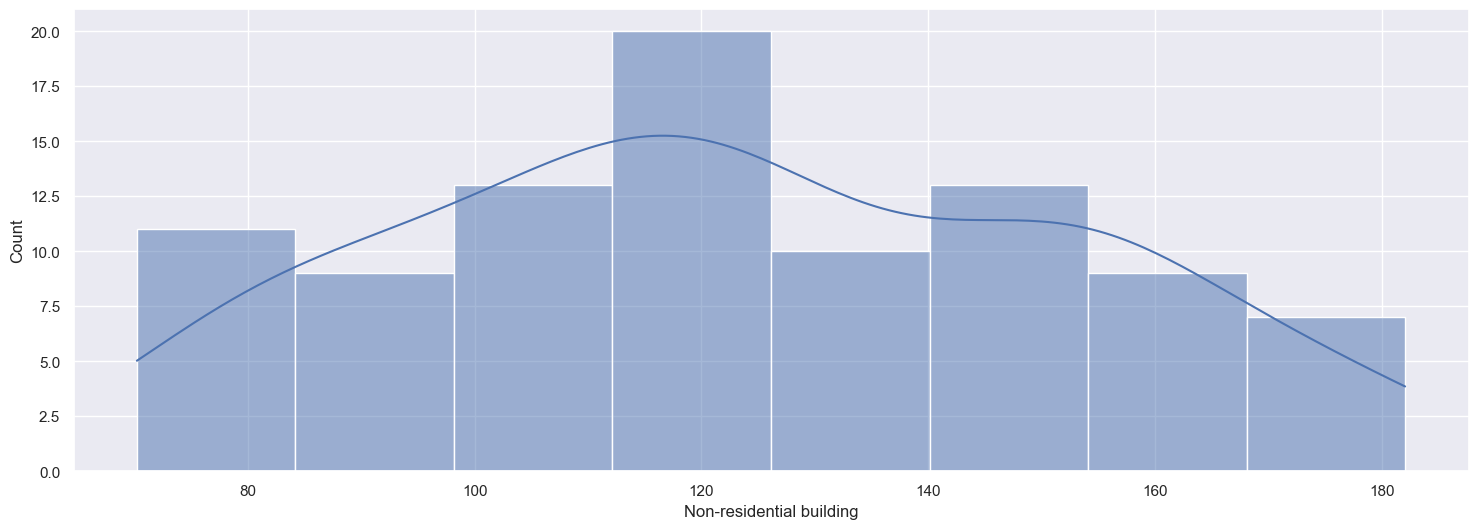

In [19]:
# Plotting distribution of production for Non-residential building
sns.histplot(value_of_production_df['Non-residential building'], kde=True)

In [20]:
# Combine the two datasets for exploring the relationship
value_prod_index_with_materials_cost_df = construction_materials_price_df.merge(value_of_production_df)
value_prod_index_with_materials_cost_df.shape

(96, 46)

In [21]:
# Draw scatter plots between each construction material price index and value of production in Non-residential building
# NOTE 1: It is only representing a subset of the production dataset, and might not represent wholistic relationship
# between available construction materials and the construction type
# NOTE 2: The time period for construction material dataset is monthly, whereas it is quarterly for production in construction.
# Due to this, after merging the two, there are 3 duplicate values for each production value to match the monthly data in materials.
scatter_plots = []
for material in construction_materials_price_df.columns[:-1]: # Except last column i.e. Quarter
    scatter_plots.append(value_prod_index_with_materials_cost_df.hvplot.scatter(x=material, y='Non-residential building', label=material, width=200))

fig = scatter_plots[0]
for plot in scatter_plots[1:]:
    # Overlaying the scatter plots becomes too congested, so laying them out separately
    fig += plot
hv.Layout(fig).cols(5)

:Layout
   .Scatter.All_other_materials                                                                   :Scatter   [All other materials]   (Non-residential building)
   .Scatter.All_other_metal_fittings                                                              :Scatter   [All other metal fittings]   (Non-residential building)
   .Scatter.All_other_products                                                                    :Scatter   [All other products]   (Non-residential building)
   .Scatter.Bituminous_emulsions                                                                  :Scatter   [Bituminous emulsions]   (Non-residential building)
   .Scatter.Bituminous_macadam_and_asphalt                                                        :Scatter   [Bituminous macadam and asphalt]   (Non-residential building)
   .Scatter.Bituminous_macadam_comma_asphalt_and_bituminous_emulsions                             :Scatter   [Bituminous macadam, asphalt and bituminous emulsions]   (Non-residential building)
   .Scatter.Cement                                                                                :Scatter   [Cement]   (Non-residential building)
   .Scatter.Concrete_blocks_and_bricks                                                            :Scatter   [Concrete blocks and bricks]   (Non-residential building)
   .Scatter.Copper_pipes_and_fittings                                                             :Scatter   [Copper pipes and fittings]   (Non-residential building)
   .Scatter.Electrical_fittings                                                                   :Scatter   [Electrical fittings]   (Non-residential building)
   .Scatter.Glass                                                                                 :Scatter   [Glass]   (Non-residential building)
   .Scatter.HVAC_left_parenthesis_heating_and_ventilation_equipment_right_parenthesis             :Scatter   [HVAC (heating and ventilation equipment)]   (Non-residential building)
   .Scatter.Insulating_materials                                                                  :Scatter   [Insulating materials]   (Non-residential building)
   .Scatter.Lighting_equipment                                                                    :Scatter   [Lighting equipment]   (Non-residential building)
   .Scatter.Machined_comma_treated_engineered_timber                                              :Scatter   [Machined, treated engineered timber]   (Non-residential building)
   .Scatter.Materials                                                                             :Scatter   [Materials]   (Non-residential building)
   .Scatter.Other_concrete_products_left_parenthesis_excluding_precast_concrete_right_parenthesis :Scatter   [Other concrete products (excluding precast concrete)]   (Non-residential building)
   .Scatter.Other_concrete_products_including_precast                                             :Scatter   [Other concrete products including precast]   (Non-residential building)
   .Scatter.Other_steel_products                                                                  :Scatter   [Other steel products]   (Non-residential building)
   .Scatter.Other_structural_steel                                                                :Scatter   [Other structural steel]   (Non-residential building)
   .Scatter.Other_treated_timber                                                                  :Scatter   [Other treated timber]   (Non-residential building)
   .Scatter.PVC_pipes_and_fittings                                                                :Scatter   [PVC pipes and fittings]   (Non-residential building)
   .Scatter.Paints_comma_oils_and_varnishes                                                       :Scatter   [Paints, oils and varnishes]   (Non-residential building)
   .Scatter.Pipes_and_fittings                                                                    :Scatter   [Pipes and fittings]   (Non-residential building)
   .Scatter.Plaster  

#### Correlation Analysis

In [22]:
target = 'Non-residential building'
features = list(construction_materials_price_df.columns[:-1])

# Select k best features based on correlation coefficients
k = 10
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(value_prod_index_with_materials_cost_df[features], value_prod_index_with_materials_cost_df[target])
features = value_prod_index_with_materials_cost_df[features].columns[selector.get_support()]

print(f'The {k} selected features based on Pearson correlation coefficients are:\n {", ".join(features)}')

# Compute Pearson correlation coefficients
features_target = list(features) + [target]
corr = value_prod_index_with_materials_cost_df[features_target].corr(method='pearson')
# Create a DF to plot with hvplot
corr_df = pd.DataFrame(corr, index=features_target, columns=features_target)
# Plot a heatmap
display(corr_df[features].hvplot.heatmap(width=800, height=600).opts(xrotation=45, default_tools=[]))

# Order the feature with the highest correlation with the target
corr_with_target = corr[target].abs().sort_values(ascending=False)

# Get the most important feature
print(f'\nThe most important feature is "{corr_with_target.index[1]}" with {round(corr_with_target[1], 4)}')

The 10 selected features based on Pearson correlation coefficients are:
 All other metal fittings, Cement, HVAC (heating and ventilation equipment), Other steel products, PVC pipes and fittings, Paints, oils and varnishes, Plaster, Precast concrete, Rough timber (hardwood), Wooden windows and doors


:HeatMap   [columns,index]   (value)


The most important feature is "All other metal fittings" with 0.8149


### Inferential Statistics

#### Pearson Correlation Coefficient Test
Let's state the Null Hypothesis:
- **Null Hypothesis (H0):** There is no correlation between each of the 10 selected construction materials and the value of production in Non-residential buildings.
- **Alternative Hypothesis (H1):** There is a correlation between each of the 10 selected construction materials and the value of production in Non-residential buildings (the population correlation coefficient is not zero for at least one construction material).
- **Significance Level (alpha):** 5% (0.05)

In [23]:
sample_size = value_prod_index_with_materials_cost_df.shape[0]
hypothetical_test_results = []
alpha=0.05  # Significance level
for feature in features: # Top 10 features from above correlation
    # Calculate the correlation coefficient and p-value
    correlation_coefficient, p_value = stats.pearsonr(value_prod_index_with_materials_cost_df[feature], value_prod_index_with_materials_cost_df[target])
    
    # Perform Fisher transformation to obtain confidence interval
    # https://blogs.sas.com/content/iml/2017/09/20/fishers-transformation-correlation.html
    z = np.arctanh(correlation_coefficient)
    
    # Calculate standard error
    se = 1 / np.sqrt(sample_size - 3)
    
    # Calculate margin of error
    margin_of_error = stats.t.ppf(0.975, sample_size - 2) * se   # alpha=0.05 -> 0.975

    # Calculate confidence interval
    lower_bound = np.tanh(z - margin_of_error)
    upper_bound = np.tanh(z + margin_of_error)

    # Add the result to list
    hypothetical_test_results.append({
        'Material': feature,
        'Coefficient': correlation_coefficient,
        'p-value': p_value,
        'accept H0': True if p_value >= alpha else False,
        'confidence interval': f'{round(lower_bound, 3)}-{round(upper_bound, 3)}'
    })
pd.DataFrame(hypothetical_test_results)

,Material,Coefficient,p-value,accept H0,confidence interval
0,All other metal fittings,0.814911,5.419483e-24,False,0.733-0.873
1,Cement,0.750128,1.421157e-18,False,0.645-0.827
2,HVAC (heating and ventilation equipment),0.742812,4.573935e-18,False,0.636-0.822
3,Other steel products,0.735394,1.438152e-17,False,0.626-0.817
4,PVC pipes and fittings,0.698355,2.589154e-15,False,0.577-0.789
5,"Paints, oils and varnishes",0.797549,2.381846e-22,False,0.709-0.861
6,Plaster,0.700247,2.024512e-15,False,0.58-0.791
7,Precast concrete,0.729288,3.589822e-17,False,0.618-0.812
8,Rough timber (hardwood),0.687658,1.004452e-14,False,0.563-0.782
9,Wooden windows and doors,0.687138,1.071252e-14,False,0.563-0.781


For all 10 selected construction materials, the p-value was less than the significance level. Therefore, the Null hypothesis is rejected. There is a statistically significant correlation between the selected construction material and the production in construction of Non-residential buildings.<br><br>
Additionally, the confidence interval shows the estimated range of plausible values for the true population correlation coefficient. It provides a sense of the precision and uncertainty that are associated with the estimated correlation coefficient. For above construction materials and construction type, the confidence interval doesn't include 0, so the correlation coefficient is statistically significant and shouldnt' have occurred by coincidence alone.

### T-test to calculate confidence intervals for population
Taking the price indices for construction materials, the standard deviation of the population isn't known. So, t-test is being used here.<br>
The hypothesized population mean is 110.

- **Null Hypothesis H0:** There is no difference between the sample mean and population mean.
- **Alternative Hypothesis H1:** The sample mean and population mean are different.
- **Significance Level (alpha):** 5% (0.05)

In [24]:
population_mean = 110

hypothetical_test_results = []
for feature in features:
    sample = value_prod_index_with_materials_cost_df[feature]
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(sample, population_mean)
    
    # Calculate the degrees of freedom
    degrees_of_freedom = len(sample) - 1

    # Calculate the standard error of the mean
    standard_error = np.std(sample, ddof=1) / np.sqrt(len(sample))

    # Calculate the margin of error
    margin_of_error = stats.t.ppf(0.975, degrees_of_freedom) * standard_error

    # Calculate the confidence interval
    confidence_interval = (round(np.mean(sample) - margin_of_error, 3), round(np.mean(sample) + margin_of_error, 3))
    
    hypothetical_test_results.append({
        'Material': feature,
        'T-statistic': round(t_statistic, 3),
        'p-value': round(p_value, 5),
        'Accept H0': True if p_value >= alpha else False,
        'confidence interval': f'{confidence_interval}'
    })
    
pd.DataFrame(hypothetical_test_results)

,Material,T-statistic,p-value,Accept H0,confidence interval
0,All other metal fittings,-3.502,0.00071,False,"(107.016, 109.175)"
1,Cement,3.190,0.00193,False,"(112.034, 118.739)"
2,HVAC (heating and ventilation equipment),-12.498,0.00000,False,"(103.421, 105.225)"
3,Other steel products,-11.535,0.00000,False,"(102.627, 104.792)"
4,PVC pipes and fittings,2.591,0.01108,False,"(111.064, 118.044)"
5,"Paints, oils and varnishes",3.144,0.00222,False,"(111.614, 117.146)"
6,Plaster,3.989,0.00013,False,"(114.295, 122.805)"
7,Precast concrete,1.987,0.04980,False,"(110.002, 115.548)"
8,Rough timber (hardwood),-3.649,0.00043,False,"(104.665, 108.425)"
9,Wooden windows and doors,-2.006,0.04765,False,"(105.667, 109.977)"


For the selected construction materials, the t-statistic is negative for some materials and postive for others. The negative t-statistic value would indicate that the sample mean is below the hypothesized population mean. Whereas the positive t-statistic value would indicate that the sample mean is above the hypothesized population mean. In either cases, the p_values are lower than the significance level of 0.05, so there is sufficient evidence to reject the Null hypothesis. <br><br>

The p_value was very close to 0.05 (current alpha) for **Precast concrete**. If the p_value is rounded to lower decimal digits, the Null hypothesis cannot be rejected with sufficient evidence. Additionally, its confidence interval (110.002, 115.548) is very close to the hypothesized population mean.

### Similarities between Ireland and Netherlands
Parametric and Non-parametric inferential statistical techniques

In [25]:
# Loading and preparing the dataset for Netherlands
netherlands_dwelling_input_cost_df = pd.read_csv('datasets/New_dwellings__input_indices_2015_100__20052023_230741.csv', sep=';')
netherlands_dwelling_input_cost_df.shape

(78, 4)

In [26]:
# Filter out the building materials price index
netherlands_materials_price_df = netherlands_dwelling_input_cost_df[netherlands_dwelling_input_cost_df['Cost components'] == 'Building materials'].copy()

# Replace the ',' with '.' in the price index, and make it as float
netherlands_materials_price_df['Input price indices (2015=100)'] = netherlands_materials_price_df['Input price indices (2015=100)'].astype('str').str.replace(',', '.').astype('float')
netherlands_materials_price_df.head()

,Cost components,Periods,Input price indices (2015=100),Changes compared to one year earlier (%)
52,Building materials,2012,99.8,NaN
53,Building materials,2013,98.4,"-1,4"
54,Building materials,2014,98.3,"-0,1"
55,Building materials,2015,100.0,"1,7"
56,Building materials,2016,101.7,"1,7"


In [27]:
print('Descriptive statistics of Netherlands dataset:')
netherlands_materials_price_df.describe()

Descriptive statistics of Netherlands dataset:


,Input price indices (2015=100)
count,26.000000
mean,125.411538
std,17.542960
min,98.300000
25%,107.600000
50%,134.750000
75%,139.500000
max,145.900000


Its mean is lower than the median, showing a negative skew.

#### Independent Samples t-test
Stating the null hypothesis
- **Null Hypothesis H0:** There is no difference between the mean cost indices
- **Alternate Hypothesis H1:** There is a difference
- **Significance Level (alpha):** 5% (0.05)

In [28]:
# Defining the 2 samples
# Get average yearly price index of all the listed materials for closer comparision
yearly_ireland_production_df = value_prod_index_with_materials_cost_df[value_prod_index_with_materials_cost_df.columns[:-5]]
yearly_ireland_production_df['year'] = yearly_ireland_production_df['Quarter'].apply(lambda x: x.split('Q')[0])
ireland_sample = yearly_ireland_production_df.groupby(['year']).mean().reset_index().iloc[:, 1:].mean(axis=1).values

netherlands_sample = netherlands_materials_price_df['Input price indices (2015=100)']

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(ireland_sample, netherlands_sample)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -2.2823370156110325
P-value: 0.029259794194400182


Above t-statistic and p-value suggest a significant difference between the mean building material cost indices of the two countries. Since the p-value is lower than the significance level of 0.05, the Null Hypothesis is rejected. Therefore, there is sufficient evidence to suggest that the means of the two countries are different.

#### Analysis of Variance

In [29]:
# Source: https://ec.europa.eu/eurostat/web/products-datasets/-/teiis500
url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/teiis500?format=TSV"
res = requests.get(url)
res

<Response [200]>

In [30]:
eu_prod_construction_df = pd.read_csv(StringIO(res.text), delimiter='\t')
eu_prod_construction_df.head()

,"freq,indic_bt,nace_r2,unit,geo\TIME_PERIOD",2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04
0,"M,PROD,F,I2015_SCA,AT",133.5,130.4,128.7,130.1,129.1,130.0,132.3,128.8,133.3,146.2,130.3 p,:
1,"M,PROD,F,I2015_SCA,BE",99.4,98.7,100.5,99.1,98.1,98.3,99.9,99.3,97.9,100.6,98.4,:
2,"M,PROD,F,I2015_SCA,BG",91.8,90.4,89.9,90.2,90.0,90.6,90.9,89.4,89.8,89.5,90.2 p,:
3,"M,PROD,F,I2015_SCA,CZ",109.9,109.4,105.9,107.5,105.5,108.5,108.4,108.2,113.6,109.3,108.3,:
4,"M,PROD,F,I2015_SCA,DE",113.8,113.1,112.2,110.9,110.9,113.3,111.1,103.2,116.9,117.2,111.8,:


In [31]:
# Taking out country, and unit of measurement to separate columns
eu_prod_construction_df['country'] = eu_prod_construction_df['freq,indic_bt,nace_r2,unit,geo\TIME_PERIOD'].apply(lambda x: x.split(',')[4])
eu_prod_construction_df['stats'] = eu_prod_construction_df['freq,indic_bt,nace_r2,unit,geo\TIME_PERIOD'].apply(lambda x: x.split(',')[3])

# Drop the 'freq,indic_bt,nace_r2,unit,geo\TIME_PERIOD' column
eu_prod_construction_df.drop(columns=['freq,indic_bt,nace_r2,unit,geo\TIME_PERIOD'], axis=1, inplace=True)

# Melt the DF to have columns 'stats', 'country', 'month' and 'value'
eu_prod_construction_df = eu_prod_construction_df.melt(id_vars=['stats', 'country'], var_name='month', value_name="value")

# Some values aren't in float format eg. '124 p', and also contain random values like ":"
# Cleaning up and casting them to float dtype
eu_prod_construction_df['value'] = eu_prod_construction_df['value'].apply(cast_to_float).dropna()

# Convert to correct datatypes
eu_prod_construction_df['stats'] = eu_prod_construction_df['stats'].astype('str')
eu_prod_construction_df['country'] = eu_prod_construction_df['country'].astype('str')
eu_prod_construction_df['month'] = pd.to_datetime(eu_prod_construction_df['month']+'-01', format='%Y-%m -%d')
eu_prod_construction_df['quarter'] = eu_prod_construction_df['month'].dt.to_period('Q').astype('str')

eu_prod_construction_df.head()

,stats,country,month,value,quarter
0,I2015_SCA,AT,2022-05-01,133.5,2022Q2
1,I2015_SCA,BE,2022-05-01,99.4,2022Q2
2,I2015_SCA,BG,2022-05-01,91.8,2022Q2
3,I2015_SCA,CZ,2022-05-01,109.9,2022Q2
4,I2015_SCA,DE,2022-05-01,113.8,2022Q2


In [32]:
# Group by quarter and get the average because Ireland's production in construction dataset is quaterly
eu_prod_construction_quaterly_df = eu_prod_construction_df.groupby(['stats', 'country', 'quarter']).mean().reset_index().dropna()
eu_prod_construction_quaterly_df.head()

,stats,country,quarter,value
0,I2015_SCA,AT,2022Q2,131.950000
1,I2015_SCA,AT,2022Q3,129.300000
2,I2015_SCA,AT,2022Q4,130.366667
3,I2015_SCA,AT,2023Q1,136.600000
5,I2015_SCA,BE,2022Q2,99.050000


Mapping of stats code to statistic label for Production in Construction:
- 'I2015_SCA': 'Index, 2015=100 (SCA)',
- 'PCH_M12_CA': 'Percentage Change m/m-12 (CA)',
- 'PCH_M1_SCA': 'Percentage Change m/m-1 (CSA)'

##### Levene's Test
Assessing the equality of variances<br>
Stating the null hypothesis
- **Null Hypothesis H0:** Population variances are equal.
- **Alternate Hypothesis H1:** Population variances aren't equal.
- **Significance Level (alpha):** 5% (0.05)

In [33]:
# Defining the samples
netherlands_sample = eu_prod_construction_quaterly_df[(eu_prod_construction_quaterly_df['country']=='NL') & (eu_prod_construction_quaterly_df['stats'] == 'I2015_SCA')]['value'].values
germany_sample = eu_prod_construction_quaterly_df[(eu_prod_construction_quaterly_df['country']=='DE') & (eu_prod_construction_quaterly_df['stats'] == 'I2015_SCA')]['value'].values
belgium_sample = eu_prod_construction_quaterly_df[(eu_prod_construction_quaterly_df['country']=='BE') & (eu_prod_construction_quaterly_df['stats'] == 'I2015_SCA')]['value'].values
ireland_sample = value_of_production_df['All building and construction'].tail(4).values

In [34]:
# Perform the Levene's Test on same samples from above
_, p_value = stats.levene(netherlands_sample, germany_sample, belgium_sample, ireland_sample, center='mean')
print("P-value with mean as center:", p_value)

_, p_value = stats.levene(netherlands_sample, germany_sample, belgium_sample, ireland_sample)
print("P-value with median as center:", p_value)

P-value with mean as center: 0.020430497847734177
P-value with median as center: 0.03725059267994974


Since the p-value is much smaller than significance level of 0.05, the Null hypothesis is rejected. Therefore, there is a significant differences in the variances of the production in construction indices among the chosen countries.

##### ANOVA
Comparing means of more than two groups<br><br>
Stating the null hypothesis
- **Null Hypothesis H0:** There is no difference in means of production in construction across different countries.
- **Alternate Hypothesis H1:** There is a difference between means across countries.
- **Significance Level (alpha):** 5% (0.05)

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create a DataFrame
group_data = pd.DataFrame({'Netherlands': netherlands_sample, 'Germany': germany_sample, 'Belgium': belgium_sample, 'Ireland:': ireland_sample})
# Melt the DataFrame for ANOVA
melted_data = pd.melt(group_data, var_name='Country', value_name='Value')

# Perform Welch's ANOVA
model = ols('Value ~ C(Country)', data=melted_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Print the results
print("Welch's ANOVA")
print(anova_result)

Welch's ANOVA
                  sum_sq    df           F        PR(>F)
C(Country)  10591.508264   3.0  362.028523  4.971438e-12
Residual      117.024020  12.0         NaN           NaN


Based on above test results, the f-value of 355.27 suggests there might be some differences in means of the countries. And the p-value is less than the chosen significance level of 0.05, so the Null hypothesis is rejected. Therefore, there is sufficient evidence to suggest statistically significant differences between the mean production in construction indices of these countries.

##### Mann-Whitney U Test 
Stating the null hypothesis
- **Null Hypothesis H0:** There is no significant difference between the production in construction indices between Ireland and Netherlands.
- **Alternate Hypothesis H1:** There is difference between the two countries
- **Significance Level (alpha):** 5% (0.05)

In [36]:
# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(ireland_sample, netherlands_sample)

# Print the test statistic and p-value
print("Mann-Whitney U Test Statistic:", statistic)
print("Mann-Whitney U Test p-value:", p_value)

Mann-Whitney U Test Statistic: 16.0
Mann-Whitney U Test p-value: 0.02857142857142857


The p-value of 0.028 is higher than 0.05, so the null hypothesis cannot be rejected. Therefore, there is insufficient evidence to conclude that the production in construction indices are significantly different between Ireland and Netherlands.

#####  Wilcoxon Signed-rank Test
Stating the null hypothesis
- **Null Hypothesis H0:** There is no significant difference between the production in construction indices in Netherlands before and after 3rd quarter of 2022.
- **Alternate Hypothesis H1:** There is difference between the group of production in construction indices.
- **Significance Level (alpha):** 5% (0.05)

In [37]:
# Create two samples from change in production in construction for Netherlands
netherlands_samples = eu_prod_construction_df[(eu_prod_construction_df['stats'] == 'PCH_M1_SCA') & (eu_prod_construction_df['country'] == 'NL')]['value'].values
netherlands_before = netherlands_samples[:6]
netherlands_after = netherlands_samples[6:]

In [38]:
# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(netherlands_before, netherlands_after)

# Print the test statistic and p-value
print("Wilcoxon Test Statistic:", statistic)
print("Wilcoxon Test p-value:", p_value)

Wilcoxon Test Statistic: nan
Wilcoxon Test p-value: nan


From above test results, the p-value is higher than 0.05, so the null hypothesis cannot be rejected. Therefore, there is no sufficient evidence to conclude that there is a significant different in the production in construction indices between the two groups.

## Machine Learning

In [39]:
# Filter the production indices 
value_prod_index_df = total_production_indices_df[total_production_indices_df['Statistic Label'] == 'Value of Production Index in Building and Construction (Seasonally Adjusted)']
value_prod_index_df = value_prod_index_df.pivot(index='Quarter', columns='Type of Building and Construction', values='VALUE').reset_index()
value_prod_index_df.head(2)

Type of Building and Construction,Quarter,All building and construction,Building (excluding civil engineering),Civil engineering,Non-residential building,Residential building
0,2000Q1,148.962898,192.043996,58.781197,119.454102,297.635955
1,2000Q2,154.184897,197.648074,62.255066,121.366028,307.404645


In [40]:
# Join the materials cost DF with Value of production
value_prod_index_with_materials_cost_df = construction_materials_price_df.merge(value_prod_index_df) #.drop(columns=['Quarter'], axis=1)
value_prod_index_with_materials_cost_df.shape

(96, 46)

In [41]:
# Do same steps for the volume of production
volume_prod_index_df = total_production_indices_df[total_production_indices_df['Statistic Label'] == 'Volume of Production Index in Building and Construction (Seasonally Adjusted)']
volume_prod_index_df = volume_prod_index_df.pivot(index='Quarter', columns='Type of Building and Construction', values='VALUE').reset_index()

# Join the materials cost DF with volume of production
volume_prod_index_with_materials_cost_df = construction_materials_price_df.merge(volume_prod_index_df)  #.drop(columns=['Quarter'], axis=1)
volume_prod_index_with_materials_cost_df.shape

(96, 46)

In [42]:
# Commenting these lines because it takes a while and generates a report above 60MB
# Creating Pandas Profile for the joined dataset
# profile = pandas_profiling.ProfileReport(value_prod_index_with_materials_cost_df)

# Save the report as an HTML file
# profile.to_file("value_prod_index_with_materials_cost_df_report.html")

### Regression Models

### Linear Regression

In [43]:
# Create dataset from dependent features and target variable
X = value_prod_index_with_materials_cost_df.iloc[:, :-6]  # All Construction materials
y = value_prod_index_with_materials_cost_df['Residential building']   # Residential building
perform_regression(LinearRegression(), X, y)

[LinearRegression(), 0.8183220090293563, 0.29069747763593645]

In [44]:
print("Value of Production Index in Building and Construction (Seasonally Adjusted):")
X = value_prod_index_with_materials_cost_df.iloc[:, :-6]  # All Construction materials
# Run regression for each bulding types
regression_results = []
for dep_col in value_prod_index_with_materials_cost_df.columns[-5:]:
    y = value_prod_index_with_materials_cost_df[dep_col]
    regression_result = perform_regression(LinearRegression(), X, y)
    regression_result.insert(0, dep_col)
    regression_results.append(regression_result)
    
pd.DataFrame(regression_results, columns=['Target', 'Model', 'Training Score', 'Testing Score'])

Value of Production Index in Building and Construction (Seasonally Adjusted):


,Target,Model,Training Score,Testing Score
0,All building and construction,LinearRegression(),0.928764,0.090405
1,Building (excluding civil engineering),LinearRegression(),0.930123,0.347483
2,Civil engineering,LinearRegression(),0.823045,-0.272174
3,Non-residential building,LinearRegression(),0.942875,0.490490
4,Residential building,LinearRegression(),0.818322,0.290697


In [45]:
print("Volume of Production Index in Building and Construction (Seasonally Adjusted):")
X = volume_prod_index_with_materials_cost_df.iloc[:, :-6]  # All Construction materials
# Run regression for each bulding types
regression_results = []
for dep_col in volume_prod_index_with_materials_cost_df.columns[-5:]:
    y = volume_prod_index_with_materials_cost_df[dep_col]
    regression_result = perform_regression(LinearRegression(), X, y)
    regression_result.insert(0, dep_col)
    regression_results.append(regression_result)
    
pd.DataFrame(regression_results, columns=['Target', 'Model', 'Training Score', 'Testing Score'])

Volume of Production Index in Building and Construction (Seasonally Adjusted):


,Target,Model,Training Score,Testing Score
0,All building and construction,LinearRegression(),0.859231,-0.422585
1,Building (excluding civil engineering),LinearRegression(),0.885667,-0.174887
2,Civil engineering,LinearRegression(),0.687067,-0.874454
3,Non-residential building,LinearRegression(),0.895686,-0.014569
4,Residential building,LinearRegression(),0.805116,0.309172


Linear Regression is performing poorly for all building types. This is likely due to large number of construction materials, and not that many observations.

## Lasso Regression to help narrow down the most important construction materials

In [46]:
print("Value of Production Index in Building and Construction (Seasonally Adjusted):")
X = value_prod_index_with_materials_cost_df.iloc[:, :-6]  # All Construction materials

# Scaling or standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run Lasso regression for each bulding types
regression_results = []
for dep_col in value_prod_index_with_materials_cost_df.columns[-5:]:
    y = value_prod_index_with_materials_cost_df[dep_col]
    regression_result = perform_regression(Lasso(), X_scaled, y)
    regression_result.insert(0, dep_col)
    regression_results.append(regression_result)
    
pd.DataFrame(regression_results, columns=['Target', 'Model', 'Training Score', 'Testing Score'])

Value of Production Index in Building and Construction (Seasonally Adjusted):


,Target,Model,Training Score,Testing Score
0,All building and construction,Lasso(),0.818960,0.706304
1,Building (excluding civil engineering),Lasso(),0.826494,0.716459
2,Civil engineering,Lasso(),0.566582,0.485965
3,Non-residential building,Lasso(),0.858174,0.756326
4,Residential building,Lasso(),0.584492,0.438152


With Lasso regression, the testing scores are improving to some extent. Let's perform Lasso with different alpha values.

In [47]:
regression_results = []
# Test Lasso regression with multiple alpha values
for alpha in np.logspace(-3, 3, 7):
    for dep_col in value_prod_index_with_materials_cost_df.columns[-5:]:
        y = value_prod_index_with_materials_cost_df[dep_col]
        regression_result = perform_regression(Lasso(alpha=alpha, max_iter=1000000), X_scaled, y)
        regression_result.insert(0, dep_col)
        regression_results.append(regression_result)
    
pd.DataFrame(regression_results, columns=['Target', 'Model', 'Training Score', 'Testing Score']).sort_values(['Training Score', 'Testing Score'], ascending=False).head(5)

,Target,Model,Training Score,Testing Score
3,Non-residential building,"Lasso(alpha=0.001, max_iter=1000000)",0.935543,0.521398
8,Non-residential building,"Lasso(alpha=0.01, max_iter=1000000)",0.932156,0.676293
0,All building and construction,"Lasso(alpha=0.001, max_iter=1000000)",0.919298,0.121003
1,Building (excluding civil engineering),"Lasso(alpha=0.001, max_iter=1000000)",0.918874,0.474752
5,All building and construction,"Lasso(alpha=0.01, max_iter=1000000)",0.915876,0.371168


In [48]:
# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.001, max_iter=1000000).fit(X_train, y_train)

# Get the absolute values of coefficients from the model
coefficients = pd.Series(np.abs(lasso.coef_), index=X.columns)
# Print the top 15 coefficients with highest magnitude value
ordered_features = coefficients.sort_values(ascending=False)
print(ordered_features)

Structural steel                                        1248.992209
Structural steel fabricated metal                       1002.111083
Materials                                                323.507981
Other structural steel                                   228.083862
Reinforcing metal                                        150.733099
Structural steel and reinforcing metal                   102.306628
Rough timber (softwood)                                   97.726529
Plumbing materials including sanitary ware                43.902459
PVC pipes and fittings                                    39.650940
Ready mixed mortar and concrete                           38.636040
HVAC (heating and ventilation equipment)                  34.585077
Precast concrete                                          32.299066
All other products                                        32.178736
Other concrete products including precast                 26.864927
Other treated timber                            

Running LinearRegression with above fewer features only.

In [49]:
# Testing with different range of features in increment of 5
regression_results = []
for i in range(6,22,5):
    features = ordered_features[:i].keys()
    X = value_prod_index_with_materials_cost_df[features]
    # Run regression for each bulding types
    for dep_col in value_prod_index_with_materials_cost_df.columns[-5:]:
        y = value_prod_index_with_materials_cost_df[dep_col]
        regression_result = perform_regression(LinearRegression(), X, y)
        regression_result.insert(0, dep_col)
        regression_result.insert(0, i)
        regression_results.append(regression_result)

pd.DataFrame(regression_results, columns=['Features #', 'Target', 'Model', 'Training Score', 'Testing Score'])

,Features #,Target,Model,Training Score,Testing Score
0,6,All building and construction,LinearRegression(),0.437250,0.457061
1,6,Building (excluding civil engineering),LinearRegression(),0.422904,0.434204
2,6,Civil engineering,LinearRegression(),0.394910,0.412245
3,6,Non-residential building,LinearRegression(),0.472400,0.455922
4,6,Residential building,LinearRegression(),0.127939,0.103147
5,11,All building and construction,LinearRegression(),0.701853,0.337368
6,11,Building (excluding civil engineering),LinearRegression(),0.680509,0.217772
7,11,Civil engineering,LinearRegression(),0.569059,0.520141
8,11,Non-residential building,LinearRegression(),0.725748,0.313141
9,11,Residential building,LinearRegression(),0.426186,-0.088740


### Ridge Regression

In [50]:
# Testing with different range of features in increment of 5
regression_results = []
for i in range(6,22,5):
    features = ordered_features[:i].keys()
    X = value_prod_index_with_materials_cost_df[features]
    # Run regression for each bulding types
    for dep_col in value_prod_index_with_materials_cost_df.columns[-5:]:
        y = value_prod_index_with_materials_cost_df[dep_col]
        # Call the regression model
        regression_result = perform_regression(Ridge(), X, y)
        regression_result.insert(0, dep_col)
        regression_result.insert(0, i)
        regression_results.append(regression_result)

pd.DataFrame(regression_results, columns=['Features #', 'Target', 'Model', 'Training Score', 'Testing Score'])

,Features #,Target,Model,Training Score,Testing Score
0,6,All building and construction,Ridge(),0.425247,0.400305
1,6,Building (excluding civil engineering),Ridge(),0.413538,0.381877
2,6,Civil engineering,Ridge(),0.377515,0.369051
3,6,Non-residential building,Ridge(),0.466002,0.423278
4,6,Residential building,Ridge(),0.081470,-0.024173
5,11,All building and construction,Ridge(),0.687804,0.236309
6,11,Building (excluding civil engineering),Ridge(),0.669504,0.121918
7,11,Civil engineering,Ridge(),0.538771,0.456590
8,11,Non-residential building,Ridge(),0.717988,0.244506
9,11,Residential building,Ridge(),0.375583,-0.280853


## Classification

### Logistic Regression

In [51]:
# Taking All building and construction
# Compare the production value to previous quarter, and if greater, set the new column to 1, else to 0
value_of_production_df['is_production_growing'] = (value_of_production_df['All building and construction'] > value_of_production_df['All building and construction'].shift()).astype('int').fillna(0)
value_prod_index_with_materials_cost_df = value_prod_index_with_materials_cost_df.merge(value_of_production_df)
value_prod_index_with_materials_cost_df.shape

(96, 47)

In [52]:
X = value_prod_index_with_materials_cost_df.iloc[:, :-7]
y = value_prod_index_with_materials_cost_df['is_production_growing']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data: Standardize the features
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_result = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Classification Report:\n{classification_result}')

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.87      0.81      0.84        16

    accuracy                           0.75        20
   macro avg       0.63      0.66      0.64        20
weighted avg       0.77      0.75      0.76        20



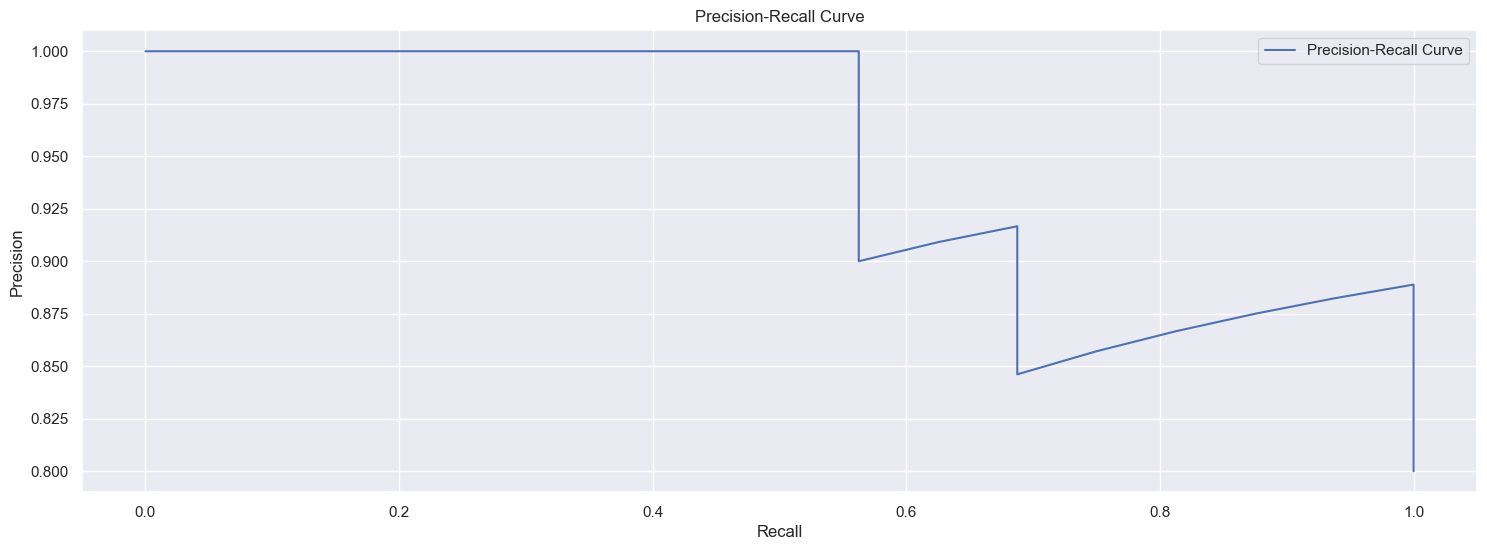

In [53]:
from sklearn.metrics import precision_recall_curve
# Make predictions on the test data
y_scores = model.decision_function(X_test)

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot precision and recall curves
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Plotting with hvplot
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
cm_df.hvplot.heatmap()

:HeatMap   [columns,index]   (value)

### Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9


### Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.85


### Support Vector Machine Classifier

In [57]:
from sklearn.svm import SVC

# Create an SVM classifier
clf = SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.85


# Sentiment Analysis
The Reddit data has been used to perform sentiment analysis. Since the regression modeling was performed on the datasets representing construction materials price indices and production in construction indices, Reddit searches were performed with similar keywords. And for comparision between multiple countries, search query were made against subreddits for Ireland and United Kingdom

## Loading Reddit Credentials

In [58]:
# # Load from the .env
# load_dotenv()

# # Get the Reddit credentials from environmental variables
# APP_NAME = getenv('APP_NAME')
# APP_ID = getenv("APP_ID")
# APP_SECRET = getenv("APP_SECRET")
# USERNAME = getenv('REDDIT_USERNAME')
# PASSWORD = getenv('PASSWORD')

# # Check that the variables all loaded
# if APP_NAME and APP_ID and APP_SECRET and USERNAME and PASSWORD:
#     print("Credentials loaded")
# else:
#     print("ERROR: Credentials not loaded!!")

In [59]:
# # Sets up the authentication part of the request
# auth = requests.auth.HTTPBasicAuth(f'{APP_ID}', f'{APP_SECRET}')

# # Sets up the data we want to send: our login method (password), username, and password
# data = {'grant_type': 'password',
#         'username': f'{USERNAME}',
#         'password': f'{PASSWORD}'}

# # Sets up this requests header info, which gives reddit a brief description of our app
# # This is the format requested by Reddit: os:app_name:version (by /u/username)
# headers = {'User-Agent': f'macos:{APP_NAME}:v1.0 (by /u/{USERNAME})'}

# # Makes the request to the access_token api endpoint, and saves the response in res
# res = requests.post('https://www.reddit.com/api/v1/access_token',
#                     auth=auth, data=data, headers=headers)

# # Converts response to JSON and pull access_token value
# TOKEN = res.json()['access_token']

# # Adds authorisation to our headers dictionary
# headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# # While the token is valid (~2 hours) we can just add headers=headers to our requests to prove authentication
# # Making a test request. <Response [200]> means that it was a success!
# requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

## Fetching data from Reddit API
Note: Depending on the amount of data being queried, this process can take some time. Since Reddit API can get throttled when exceeding the request limits, setting a slight sleep to slow down the request rates.

In [60]:
# # Creating DF from search results for "construction material price" in Reddit
# # search_reddit() is present in myutils.py
# irish_construction_posts_df = pd.DataFrame.from_dict(search_reddit(headers, "ireland", "construction material price"))
# irish_construction_posts_df.shape

In [61]:
# # Add a search column to identify the search keyword
# irish_construction_posts_df['search'] = 1

In [62]:
# # Creating DF from search results for "production in construction" in Reddit
# irish_production_construction_df = pd.DataFrame.from_dict(search_reddit(headers, "ireland", "production in construction"))
# irish_production_construction_df.shape

In [63]:
# # Add a search column to identify the search keyword
# irish_production_construction_df['search'] = 2

In [64]:
# # Concatenating the above DFs
# irish_construction_and_production_df = pd.concat([irish_construction_posts_df, irish_production_construction_df])
# irish_construction_and_production_df.shape

In [65]:
# # Since the search results are for similar/related topic, they likely have some duplicates. Hence, dropping duplicates
# irish_construction_and_production_df.drop_duplicates(subset=['created_utc', 'post_id'], inplace=True)
# irish_construction_and_production_df.shape

In [66]:
# # Sort the DF based on the creation time
# sorted_irish_construction_and_production_df = irish_construction_and_production_df.sort_values(by=['created_utc']).reset_index(drop=True)

In [67]:
# sorted_irish_construction_and_production_df.head(5)

### Data Pre Processing and Sentiment Analysis

In [68]:
# # Clean the data and run sentiment analysis using both Vader and TextBlob
# cleaned_data = get_cleaned_data(sorted_irish_construction_and_production_df['text'])
# sorted_irish_construction_and_production_df['vader_prediction'] = cleaned_data.apply(predict_sentiment)
# sorted_irish_construction_and_production_df['textblob_sentiment'] = cleaned_data.apply(get_sentiment)

In [69]:
# sorted_irish_construction_and_production_df.tail(5)

In [70]:
# diff_sia_textblob = sorted_irish_construction_and_production_df[sorted_irish_construction_and_production_df['vader_prediction'] != sorted_irish_construction_and_production_df['textblob_sentiment']].shape[0]
# print(f"Differences between Vader and TextBlob: {diff_sia_textblob}")

### Plot of SentimentIntensityAnalyzer and TextBlob

In [71]:
# # Plot the sentiment analyzed by Vader and TextBlob side-by-side
# fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
# sns.countplot(data=sorted_irish_construction_and_production_df, x='vader_prediction', ax=ax1).set(title="VADER Prediction");
# sns.countplot(data=sorted_irish_construction_and_production_df, x='textblob_sentiment', ax=ax2).set(title="TextBlob Prediction");

#### United Kingdom

In [72]:
# # Creating DF from search results for "construction material price" in Reddit
# uk_construction_materials_df = pd.DataFrame.from_dict(search_reddit(headers, "unitedkingdom", "construction material price"))
# uk_construction_materials_df.shape

In [73]:
# # Add a column to identify search results
# uk_construction_materials_df['search'] = 1

In [74]:
# # Creating DF from search results for "production in construction" in Reddit
# uk_production_construction_df = pd.DataFrame.from_dict(search_reddit(headers, "unitedkingdom", "production in construction"))
# uk_production_construction_df.shape

In [75]:
# # Add a column to identify search results
# uk_production_construction_df['search'] = 2

In [76]:
# # Concatenating the above DFs
# uk_construction_and_production_df = pd.concat([uk_construction_materials_df, uk_production_construction_df])
# uk_construction_and_production_df.shape

# # Since the search results are for similar/related topic, they likely have some duplicates. Hence, dropping duplicates
# uk_construction_and_production_df.drop_duplicates(subset=['created_utc', 'post_id'], inplace=True)
# uk_construction_and_production_df.shape

# # Sort the DF based on the creation time
# sorted_uk_construction_and_production_df = uk_construction_and_production_df.sort_values(by=['created_utc']).reset_index(drop=True)

In [77]:
# # Clean the data and run sentiment analysis using both Vader and TextBlob
# cleaned_data = get_cleaned_data(sorted_uk_construction_and_production_df['text'])
# sorted_uk_construction_and_production_df['vader_prediction'] = cleaned_data.apply(predict_sentiment)
# sorted_uk_construction_and_production_df['textblob_sentiment'] = cleaned_data.apply(get_sentiment)

In [78]:
# sorted_uk_construction_and_production_df.tail(5)

In [79]:
# diff_sia_textblob = sorted_uk_construction_and_production_df[sorted_uk_construction_and_production_df['vader_prediction'] != sorted_uk_construction_and_production_df['textblob_sentiment']].shape[0]
# print(f"Differences between Vader and TextBlob: {diff_sia_textblob}")

In [80]:
# # Plot the sentiment analyzed by Vader and TextBlob side-by-side
# fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
# sns.countplot(data=sorted_uk_construction_and_production_df, x='vader_prediction', ax=ax1).set(title="VADER Prediction");
# sns.countplot(data=sorted_uk_construction_and_production_df, x='textblob_sentiment', ax=ax2).set(title="TextBlob Prediction");

#### Netherlands

In [81]:
# # Creating DF from search results for "construction material price" in Reddit
# nl_construction_materials_df = pd.DataFrame.from_dict(search_reddit(headers, "netherlands", "construction material price"))
# nl_construction_materials_df.shape

In [82]:
# # Add a column to identify search results
# nl_construction_materials_df['search'] = 1

In [83]:
# # Creating DF from search results for "production in construction" in Reddit
# nl_production_construction_df = pd.DataFrame.from_dict(search_reddit(headers, "netherlands", "production in construction"))
# nl_production_construction_df.shape

In [84]:
# # Add a column to identify search results
# nl_production_construction_df['search'] = 2

In [85]:
# # Concatenating the above DFs
# nl_construction_and_production_df = pd.concat([nl_construction_materials_df, nl_production_construction_df])
# nl_construction_and_production_df.shape

# # Since the search results are for similar/related topic, they likely have some duplicates. Hence, dropping duplicates
# nl_construction_and_production_df.drop_duplicates(subset=['created_utc', 'post_id'], inplace=True)
# nl_construction_and_production_df.shape

# # Sort the DF based on the creation time
# sorted_nl_construction_and_production_df = nl_construction_and_production_df.sort_values(by=['created_utc']).reset_index(drop=True)

In [86]:
# # Clean the data and run sentiment analysis using both Vader and TextBlob
# cleaned_data = get_cleaned_data(sorted_nl_construction_and_production_df['text'])
# sorted_nl_construction_and_production_df['vader_prediction'] = cleaned_data.apply(predict_sentiment)
# sorted_nl_construction_and_production_df['textblob_sentiment'] = cleaned_data.apply(get_sentiment)

In [87]:
# sorted_nl_construction_and_production_df.tail(5)

In [88]:
# diff_sia_textblob = sorted_nl_construction_and_production_df[sorted_nl_construction_and_production_df['vader_prediction'] != sorted_nl_construction_and_production_df['textblob_sentiment']].shape[0]
# print(f"Differences between Vader and TextBlob: {diff_sia_textblob}")

In [89]:
# # Plot the sentiment analyzed by Vader and TextBlob side-by-side
# fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(30,6))
# sns.countplot(data=sorted_nl_construction_and_production_df, x='vader_prediction', ax=ax1).set(title="VADER Prediction");
# sns.countplot(data=sorted_nl_construction_and_production_df, x='textblob_sentiment', ax=ax2).set(title="TextBlob Prediction");

### Persist the dataset to MongoDB
Performing API calls to Reddit could result in exceeding the allowed rate limits. A delay was applied before making each GET request to prevent the throttling. When querying large amount of posts/comments, this process can take long time to complete. So, it can be more efficient to regularly persisting the data to a database, and later querying from it instead of using Reddit API all the time.

In [90]:
# # Creating MongoDB client and connection
# client = pymongo.MongoClient("mongodb://localhost:27017")
# db = client["ca2"]
# # Collection
# coll = db['production_in_construction']

In [91]:
# # Insert the Irish DF rows to MongoDB collection
# try:
#     coll.insert_many(sorted_irish_construction_and_production_df.to_dict('records'))
#     print(f"Estimated documents in MongoDB Collection: {coll.estimated_document_count()}")
# except:
#     print('Inserting to MongoDB failed!')

In [92]:
# # Insert the UK DF rows to MongoDB collection
# try:
#     coll.insert_many(sorted_uk_construction_and_production_df.to_dict('records'))
#     print(f"Estimated documents in MongoDB Collection: {coll.estimated_document_count()}")
# except:
#     print('Inserting to MongoDB failed!')

In [93]:
# # Insert the Netherlands DF rows to MongoDB collection
# try:
#     coll.insert_many(sorted_nl_construction_and_production_df.to_dict('records'))
#     print(f"Estimated documents in MongoDB Collection: {coll.estimated_document_count()}")
# except:
#     print('Inserting to MongoDB failed!')

In [94]:
# # Also saving the dataset into local JSON file to avoid having to make Reddit API calls everytime
# final_reddit_api_df = pd.concat([sorted_irish_construction_and_production_df,
#                                  sorted_uk_construction_and_production_df,
#                                  sorted_nl_construction_and_production_df
#                                 ])
# final_reddit_api_df.to_json('datasets/reddit_data.json', orient="records")

### Loading and Preparing Data from MongoDB to Create Visualization

In [103]:
try:
    # Creating MongoDB client and connection
    client = pymongo.MongoClient("mongodb://localhost:27017")
    db = client["ca2"]
    # Collection
    coll = db['production_in_construction']
    
    # Creating DFs from MongoDB collection
    results = coll.find()
    sentiment_production_in_construction_df = pd.DataFrame(list(results))
except:
    # When MongoDB read fails, creating DF from local JSON file
    print('Reading from JSON file')
    sentiment_production_in_construction_df = pd.read_json("datasets/reddit_data.json")
print('Shape: ', sentiment_production_in_construction_df.shape)

# Convert the creation time to datetime
sentiment_production_in_construction_df['created_utc'] = pd.to_datetime(sentiment_production_in_construction_df['created_utc'], unit='s')
sentiment_production_in_construction_df.head(5)

Reading from JSON file
Shape:  (19765, 8)


,created_utc,author,post_id,subreddit,text,search,vader_prediction,textblob_sentiment
0,2010-08-16 20:24:13,el-fish,d1uqp,ireland,In detroit there are companies that deconstruc...,1,negative,positive
1,2010-08-16 20:31:30,el-fish,d1uqp,ireland,Messed up that submission. Ment to link to thi...,1,negative,negative
2,2010-08-16 21:41:27,[deleted],d1uqp,ireland,As a Canadian currently looking for work in Du...,1,negative,neutral
3,2010-10-28 14:35:06,chipsambos,dxq3p,ireland,From Michael Kennedy TD:\n\n28-Oct-2010\n\nA C...,1,positive,positive
4,2010-10-28 15:30:57,keithwalsh1972,dxq3p,ireland,This shit just gets worse......\n\nWe are abou...,1,negative,negative


In [104]:
# Selecting rows that have common sentiment for Vader and Textblob
reddit_common_sentiment_df = sentiment_production_in_construction_df[sentiment_production_in_construction_df['vader_prediction'] == sentiment_production_in_construction_df['textblob_sentiment']].copy()

# Rename column
reddit_common_sentiment_df.rename(columns={"vader_prediction": "sentiment"}, inplace=True)

# Add columns year and month
reddit_common_sentiment_df['year'] = reddit_common_sentiment_df['created_utc'].dt.year
reddit_common_sentiment_df['month'] = reddit_common_sentiment_df['created_utc'].dt.to_period('M')   #month.astype('str')
# reddit_common_sentiment_df['day'] = reddit_common_sentiment_df['created_utc'].dt.day.astype('str')
# reddit_common_sentiment_df['date'] = reddit_common_sentiment_df['created_utc'].dt.to_period('D')

In [105]:
# Group the data in year level for quick comparision between Irish and European sentiment
grouped_reddit_df = reddit_common_sentiment_df.groupby(['year', 'subreddit', 'sentiment']).size().reset_index(name="count")

# Plot the line charts for Irish and European datasets
grouped_reddit_df[grouped_reddit_df['subreddit']=='ireland'].hvplot(x='year', y='count', by='sentiment', title='Ireland', width=500, height=300).opts(legend_position='top_left', default_tools=[]) + \
grouped_reddit_df[grouped_reddit_df['subreddit']=='unitedkingdom'].hvplot(x='year', y='count', by='sentiment', title='United Kingdom', width=500, height=300).opts(legend_position='top_left', default_tools=[])

:Layout
   .NdOverlay.I  :NdOverlay   [sentiment]
      :Curve   [year]   (count)
   .NdOverlay.II :NdOverlay   [sentiment]
      :Curve   [year]   (count)

### Main Dashboard
- It calls dependency functions that are imported from myutils.py
- Make sure all the required dataframes are loaded before running this part

### Preparing Panel for Sentiment Analysis

In [106]:
# Couldn't move this class to myutils.py because the exisiting DF had to be specified within this class.
# Trying to pass the DF as argument using Constructor caused the param to be not passed correctly with Panel.
# No error was returned, however the panel simply didn't work.

# Class to be used by Panel
class SentimentAnalysis(param.Parameterized):
    sentiment_production_in_construction_df.rename(columns={"vader_prediction": "VADER", "textblob_sentiment": "TextBlob"}, inplace=True)
    df = sentiment_production_in_construction_df[['created_utc', 'subreddit', 'search', 'VADER', 'TextBlob']].melt(id_vars=['created_utc', 'subreddit', 'search'], var_name='Analyzer', value_name='Sentiment')
    df['Year'] = df['created_utc'].dt.year
    
    # Dropdown for Sentiment Analyzer
    analyzer = param.Selector(objects=['VADER', 'TextBlob'])
    # Dropdown for subreddits
    subreddit = param.Selector(objects=list(df['subreddit'].unique()))

    def plot_national_sentiment(self):
        count_sentiment_df = self.df.groupby(['Year', 'subreddit', 'search', 'Analyzer', 'Sentiment']).size().reset_index(name="count")
        country_df = count_sentiment_df[(count_sentiment_df['subreddit'] == self.subreddit) & (count_sentiment_df['Analyzer'] == self.analyzer)]
        
        # Define color map for each sentiment
        colormap = {'positive': 'green', 'neutral': 'grey', 'negative': 'red'}
        
        # Create Hvplots with defined color map
        fig1_plots = []
        fig2_plots = []
        for sentiment in colormap.keys():
            fig1_plots.append(country_df[(country_df['search']==1) & (country_df['Sentiment']==sentiment)].hvplot.line(x='Year', 
                                                               y='count', color=colormap[sentiment], label=sentiment,
                                                               title=f'Trend in Sentiment about Construction Materials Prices - {self.subreddit}'
                                                              )
            )
            fig2_plots.append(
                country_df[(country_df['search']==1) & (country_df['Sentiment']==sentiment)].hvplot.line(x='Year', 
                                                               y='count', 
                                                               color=colormap[sentiment], label=sentiment,
                                                               title=f'Trend in Sentiment about Production in Construction - {self.subreddit}'
                                                              )
            )
        # Overlay lineplots
        fig1 = (fig1_plots[0] * fig1_plots[1] * fig1_plots[2]).opts(legend_position='top_left', default_tools=[])
        
        fig2 = (fig2_plots[0] * fig2_plots[1] * fig2_plots[2]).opts(legend_position='top_left', default_tools=[])
        
        counts_df = self.df[(self.df['search']==1) & (self.df['subreddit'] == self.subreddit) & (self.df['Analyzer'] == self.analyzer)]['Sentiment'].value_counts().reset_index()
        counts_df.columns = ['Sentiment', 'Count']
        fig3 = counts_df.hvplot.bar(x='Sentiment', 
                                    y='Count', 
                                    color='Sentiment', 
                                    colormap=colormap, 
                                    title=f'Overall Sentiment about Construction Materials Prices - {self.subreddit}'
                                   ).opts(legend_position='top_right', default_tools=[])
        
        counts_df = self.df[(self.df['search']==2) & (self.df['subreddit'] == self.subreddit) & (self.df['Analyzer'] == self.analyzer)]['Sentiment'].value_counts().reset_index()
        counts_df.columns = ['Sentiment', 'Count']
        fig4 = counts_df.hvplot.bar(x='Sentiment', 
                                    y='Count', 
                                    color='Sentiment', 
                                    colormap=colormap,
                                    title=f'Overall Sentiment about Production in Construction - {self.subreddit}'
                                   ).opts(legend_position='top_right', default_tools=[])

        return hv.Layout(fig1 + fig2 + fig3 + fig4).cols(2)
       
# Instantiating the class
obj = SentimentAnalysis()
obj

SentimentAnalysis(analyzer='VADER', name='SentimentAnalysis10700', subreddit='ireland')

In [107]:
# Create a panel for Sentiment Analysis to be added to main Panel dashboard
title_text = '# Sentiment Analysis of Construction Sector'
sentiment_panel = pn.Column(title_text, obj.param, obj.plot_national_sentiment)
# sentiment_panel

### Preparing Panel for Machine learning

In [108]:
# Function to run the Machine Learning model and return the Hvplot figures
def visualize_model(production_stat, model, scaler, gridsearchcv, feature):
    # Filter the production related DF with selected statistic label
    production_indices_df = total_production_indices_df[total_production_indices_df['Statistic Label']==production_stat]
    
    # Pivot the type of building/construction values to columns
    pivoted_production_df = production_indices_df.pivot(index='Quarter', columns='Type of Building and Construction', values='VALUE').reset_index()
    
    # Join it to DF containing construction materials
    combined_df = construction_materials_price_df.merge(pivoted_production_df)
    
    # Call get_model_visualization_results function to perform the actual modeling, and to create a Plotly plot
    return get_model_visualization_results(combined_df, model, scaler, gridsearchcv, feature)

In [109]:
# ridge_alphas = [Ridge(alpha=value) for value in np.logspace(-2, 2, 5)]
# lasso_alphas = [Lasso(alpha=value) for value in np.logspace(-2, 2, 5)]
# models = [LinearRegression(), *ridge_alphas, *lasso_alphas]

# Define the list of Models to select from
models = [DecisionTreeClassifier(), RandomForestClassifier(), SVC(), LogisticRegression(), LinearRegression(), Ridge(), Lasso()]

# Define the list of available statistics labels
production_statistics = total_production_indices_df['Statistic Label'].unique()

# Define the scalers
scalers = [None, StandardScaler(), MinMaxScaler()]

# Define list of features to be used for modeling
features = ['Top 5', 'Top 10', 'Top 15', 'Top 20', 'Top 25', 'All']

# Define arguments for plotting function
kw = dict(production_stat=production_statistics,
          model=models,
          scaler=scalers,
          gridsearchcv=False,
          feature=features
         )

# Create Panel interaction with custom function
i = pn.interact(visualize_model, **kw)
text = "<br>\n# Machine Learning Models"

# Define plot Row and Column
p = pn.Row(pn.Column(text, i[0][0], i[0][1], pn.Row(i[0][2], i[0][4], i[0][3]), i[1][0], sentiment_panel))

,Model,Target,Scaler,Training Score,Testing Score
0,DecisionTreeClassifier(),All building and construction,None,1.0,0.9
1,DecisionTreeClassifier(),Building (excluding civil engineering),None,1.0,0.9
2,DecisionTreeClassifier(),Civil engineering,None,1.0,0.9
3,DecisionTreeClassifier(),Non-residential building,None,1.0,0.9
4,DecisionTreeClassifier(),Residential building,None,1.0,0.9


## Interactive Dashboard
The interactive plot provides following parameters:
- **Machine Learning**:
    - Statistics Label from Indices for Production in Construction dataset: Value, Volume and their Seasonally Adjusted values.
    - Regression Models: Linear, Ridge and Lasso
    - Scaler: None, MinMaxScaler and StandardScaler
    - Features: All features, Top [5, 10, 15, 20 and 25) features selected based on coefficents from Lasso regression
    - GridSearchCV: True or False (If true, it'll run GridSearchCV on pre-defined hyperparameters, and returns the best estimator
    
- **Sentiment Analysis**:
    - Analyzer: SentimentIntensityAnalyzer with VADER and TextBlob
    - Subreddit: Ireland, UnitedKingdom and Netherlands

---
NOTE: The regression happens for all types of building and construction separately. The model results are presented separately for each construction type. This allows us to understand which construction types are closely related to the change in price of tracked construction materials.

In [113]:
# Uncomment below to display panel in cell output
# p

# Uncomment below to display dashboard in new tab
p.show()

Launching server at http://localhost:62698
